<a href="https://colab.research.google.com/github/ArthurSampaio13/TimeSeries/blob/main/Modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importando as bibliotecas

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from itertools import product
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from math import sqrt
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_squared_error as MSE

from sklearn.preprocessing import MinMaxScaler

from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor

import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from itertools import product

import warnings

warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (16, 8)

# Candy Production

### Leitura dos dados

In [ ]:
dados = pd.read_csv('/content/candy_production.csv', index_col = 0,
                    parse_dates=True)

### Breve visualização dos dados

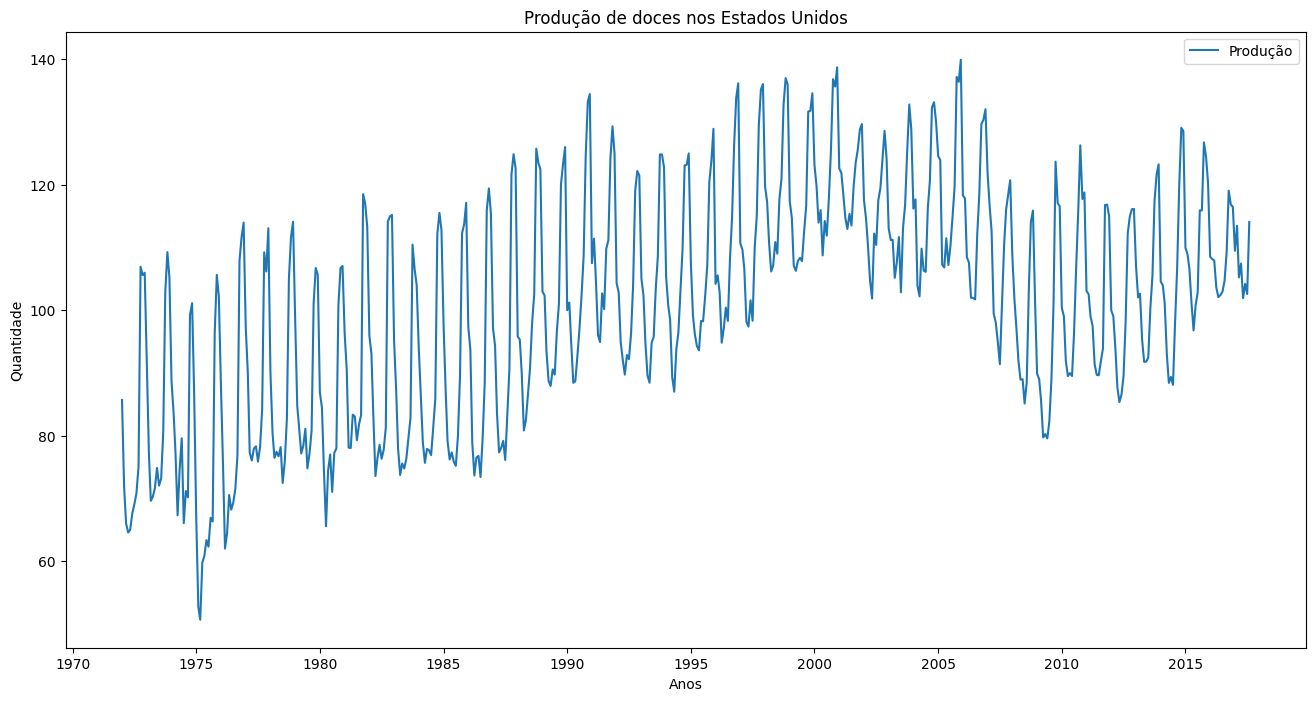

In [ ]:
plt.title("Produção de doces nos Estados Unidos")
plt.plot(dados, label='Produção')
plt.xlabel("Anos")
plt.ylabel("Quantidade")
plt.legend(loc='best')
plt.show()

## Split em treino, teste e validação

In [ ]:
train = dados.loc['1972':'2008']

val = dados.loc['2009':'2010']

test = dados.loc['2011':]

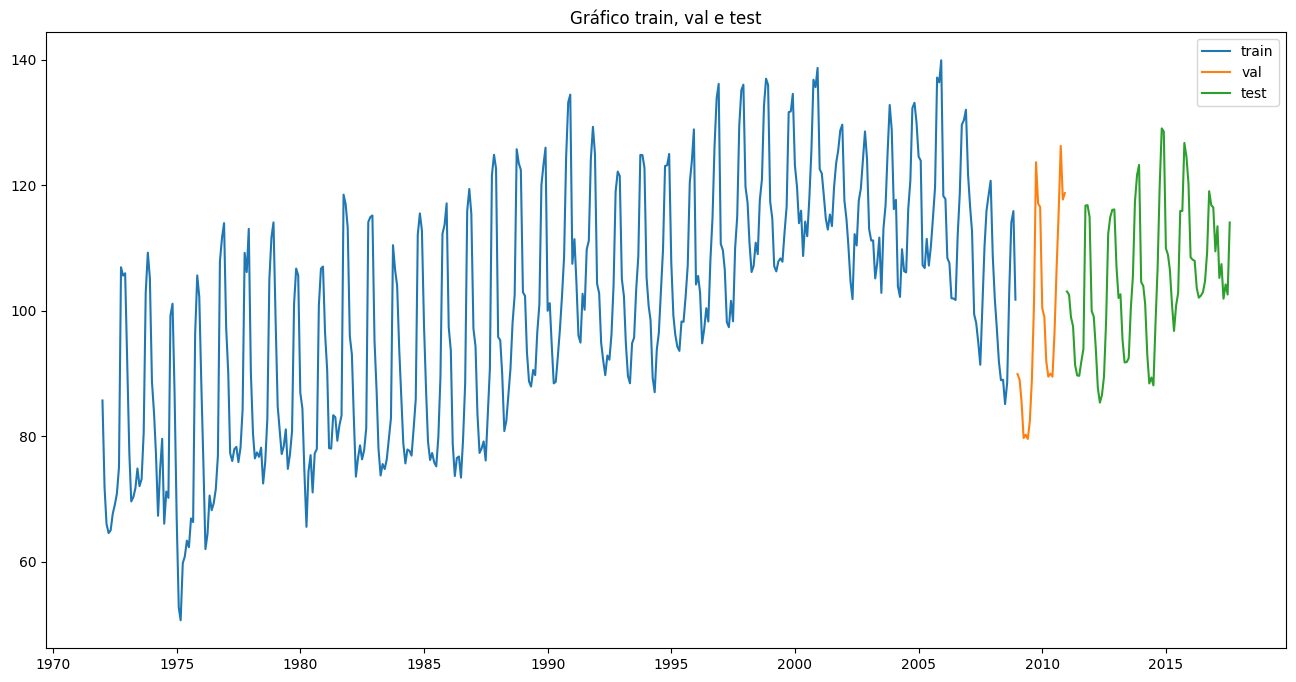

In [ ]:
plt.title("Gráfico train, val e test")
plt.plot(train, label='train')
plt.plot(val, label='val')
plt.plot(test, label='test')
plt.legend(loc='best')
plt.show()

## Normalizando os dados

In [ ]:
scaler = MinMaxScaler()

In [ ]:
scaler.fit(train.IPG3113N.values.reshape(-1, 1))

MinMaxScaler()

In [ ]:
train_norm = scaler.transform(train.IPG3113N.values.reshape(-1, 1))

val_norm = scaler.transform(val.IPG3113N.values.reshape(-1, 1))

test_norm = scaler.transform(test.IPG3113N.values.reshape(-1, 1))

## Janela deslizante

In [ ]:
def create_sliding_windows(series, window_size):

    list_of_sliding_windows = []
    list_size_to_iterate = len(series) - window_size

    for i in range(0, list_size_to_iterate):
        window = series[i: i + window_size + 1]
        list_of_sliding_windows.append(window)

    return np.array(list_of_sliding_windows).reshape(len(list_of_sliding_windows), window_size + 1)

## Gráfico ACF e PACF

In [ ]:
def acf_pacf(x, qtd_lag):
    fig = plt.figure(figsize=(16,10))
    ax1 = fig.add_subplot(221)
    fig = sm.graphics.tsa.plot_acf(x, lags=qtd_lag, ax=ax1)
    ax2 = fig.add_subplot(222)
    fig = sm.graphics.tsa.plot_pacf(x, lags=qtd_lag, ax=ax2)
    plt.show()

In [ ]:
dados.isnull().sum()

IPG3113N    0
dtype: int64

## Criando as janelas deslizantes

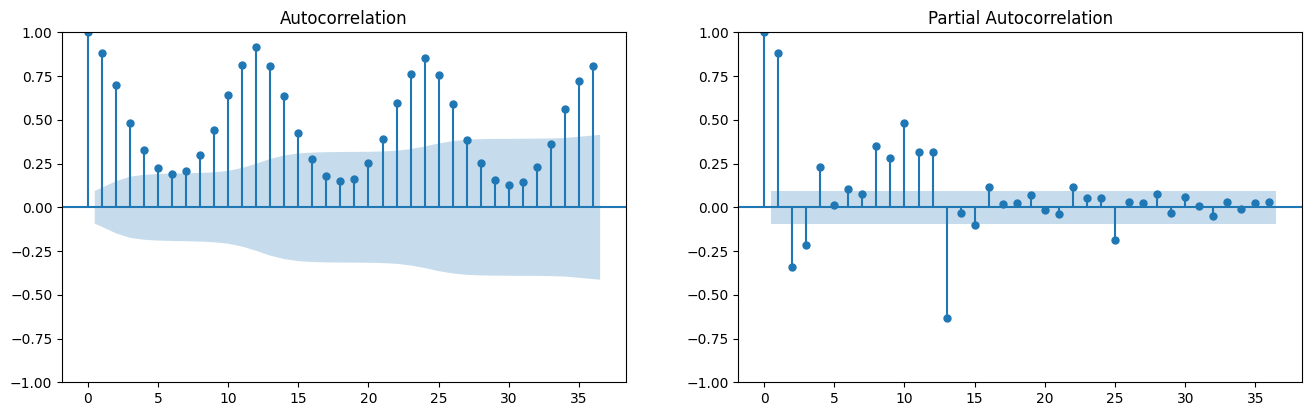

In [ ]:
acf_pacf(train_norm, 36)

> Intepretação dos resultados:
- O tamanho da minha janela seria `5`

In [ ]:
train_windows = create_sliding_windows(train_norm, 5)

val_windows = create_sliding_windows(val_norm, 5)

test_windows = create_sliding_windows(test_norm, 5)

In [ ]:
X_train = train_windows[:, 0: -1]
y_train = train_windows[:, -1]

X_val = val_windows[:, 0: -1]
y_val = val_windows[:, -1]

X_test = test_windows[:, 0: -1]
y_test = test_windows[:, -1]

# MLP

In [ ]:
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50), (50, 50, 50)],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['adam', 'lbfgs'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01, 0.1]
}

In [ ]:
best_params = None
best_mape = np.inf

In [ ]:
param_combinations = product(param_grid['hidden_layer_sizes'],
                             param_grid['activation'],
                             param_grid['solver'],
                             param_grid['alpha'],
                             param_grid['learning_rate_init'])

In [ ]:
for hidden_layer_sizes, activation, solver, alpha, learning_rate_init in param_combinations:
    model = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes,
                         activation=activation,
                         solver=solver,
                         alpha=alpha,
                         learning_rate_init=learning_rate_init,
                         max_iter=10000,
                         random_state=42)

    model.fit(X_train, y_train)

    prev_val = model.predict(X_val)
    val_mape = MAPE(y_val, prev_val)

    if val_mape < best_mape:
        best_params = {
            'hidden_layer_sizes': hidden_layer_sizes,
            'activation': activation,
            'solver': solver,
            'alpha': alpha,
            'learning_rate_init': learning_rate_init
        }
        best_mape = val_mape

In [ ]:
print("Best Parameters:")
print(best_params)

print("Best MAPE:", best_mape)

Best Parameters:
{'hidden_layer_sizes': (50, 50, 50), 'activation': 'tanh', 'solver': 'lbfgs', 'alpha': 0.0001, 'learning_rate_init': 0.001}
Best MAPE: 0.058737093149041054


### Juntando as janelas

In [ ]:
X_train_full = np.vstack([X_train, X_val])
y_train_full = np.hstack([y_train, y_val])

## Criando o modelo

In [ ]:
MLP = MLPRegressor(**best_params)


MLP.fit(X_train_full, y_train_full)

## Fazendo as previsões

In [ ]:
prev_train = MLP.predict(X_train_full)
prev_test = MLP.predict(X_test)

## Previsão em `treino`

NameError: name 'y_train_full' is not defined

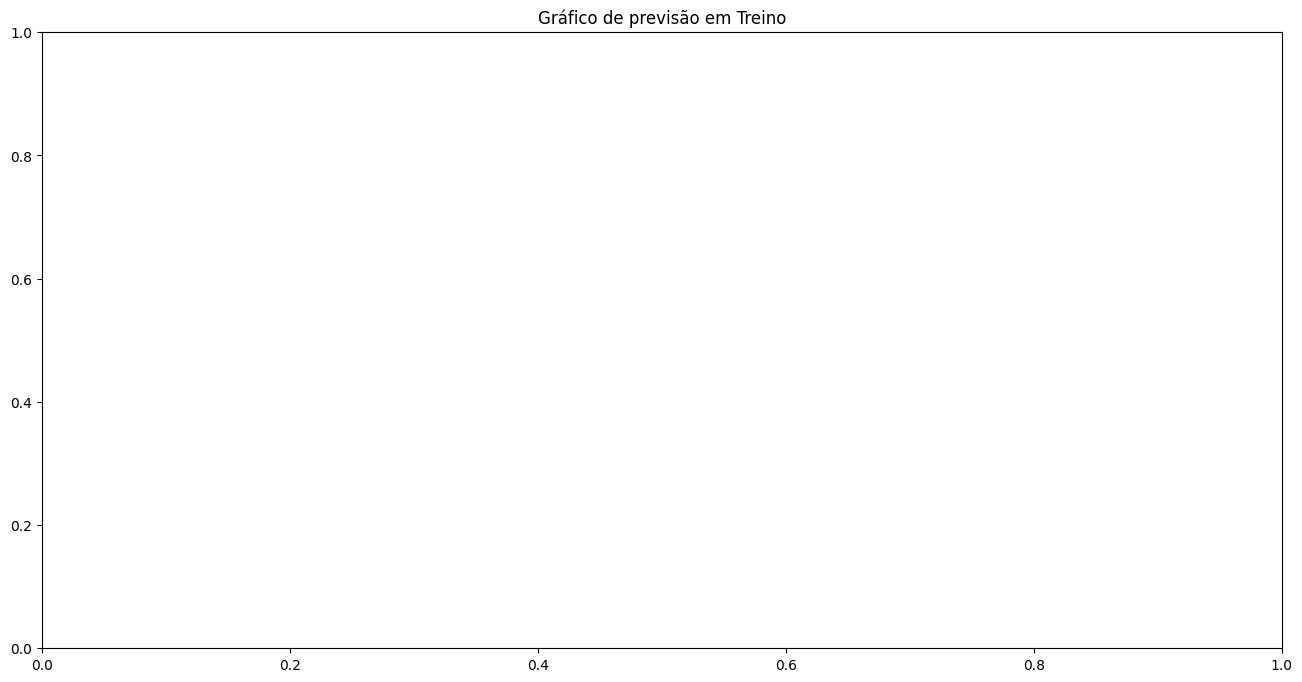

In [ ]:
plt.title('Gráfico de previsão em Treino')
plt.plot(y_train_full, label = 'target')
plt.plot(prev_train, label = 'predict')
plt.legend(loc = 'best')
plt.show()

In [ ]:
def rmse(x, y):
  return sqrt(MSE(x, y))

In [ ]:
resultados = {
    "Métricas MLP - Train": ["MAPE", "MSE", "RMSE"],
    "Resultado MLP - Train": [MAPE(y_train_full, prev_train),
                              MSE(y_train_full, prev_train),
                              rmse(y_train_full, prev_train)]
}

df_resultados_MLP_train = pd.DataFrame(resultados)
df_resultados_MLP_train.set_index("Métricas MLP - Train", inplace=True)

df_resultados_MLP_train

,Resultado MLP - Train
Métricas MLP - Train,
MAPE,0.118065
MSE,0.005596
RMSE,0.074808


## Previsão em `teste`

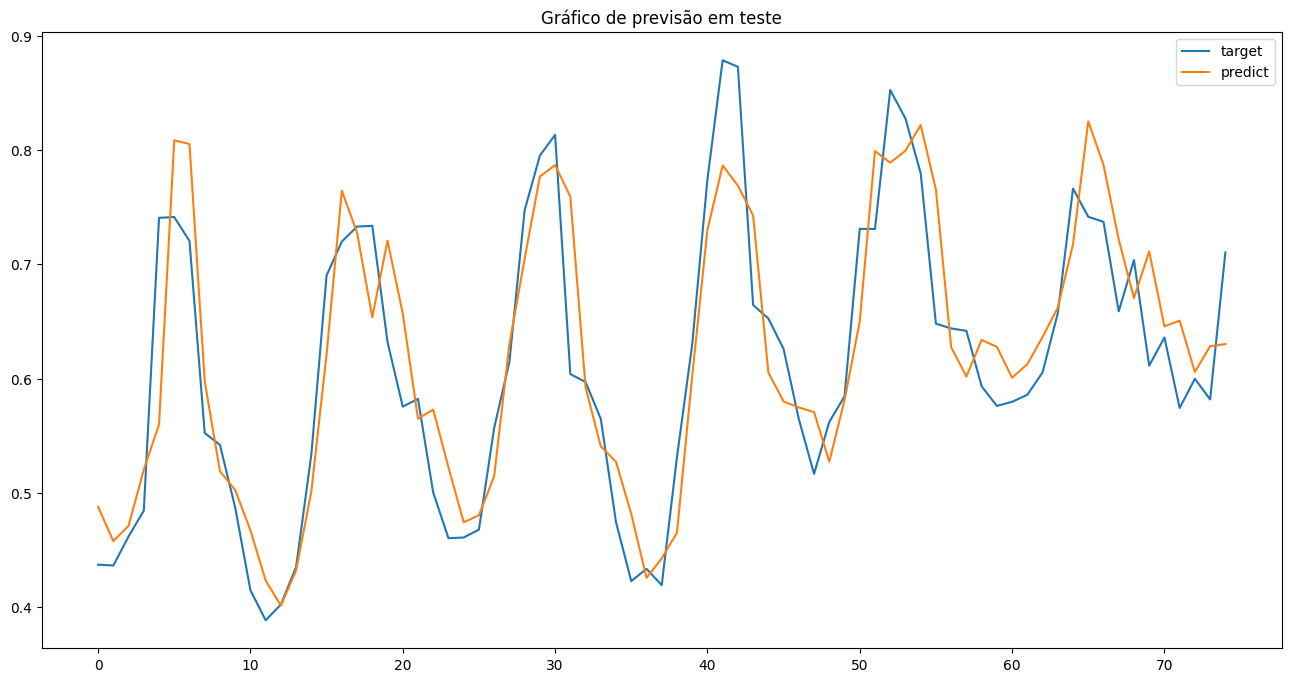

In [ ]:
plt.title("Gráfico de previsão em teste")
plt.plot(y_test, label = 'target')
plt.plot(prev_test, label = 'predict')
plt.legend(loc = 'best')
plt.show()

In [ ]:
resultados = {
    "Métricas MLP - Test": ["MAPE", "MSE", "RMSE"],
    "Resultado MLP - Test": [MAPE(y_test, prev_test),
                              MSE(y_test, prev_test),
                              rmse(y_test, prev_test)]
}

df_resultados_MLP_test = pd.DataFrame(resultados)
df_resultados_MLP_test.set_index("Métricas MLP - Test", inplace=True)

df_resultados_MLP_test

,Resultado MLP - Test
Métricas MLP - Test,
MAPE,0.073634
MSE,0.003369
RMSE,0.058042


# XgBoost

### GridSearch para encontrar os melhores parâmetros

In [ ]:
xgb = XGBRegressor()

In [ ]:
parametros = {'max_depth': [3,],
              'learning_rate': [0.1, 0.01, 0.001],
              'n_estimators' : [x for x in range(2, 201)]}

In [ ]:
best_mape = float('inf')
best_params = {}

In [ ]:
for max_depth in parametros['max_depth']:
    for learning_rate in parametros['learning_rate']:
        modelo = XGBRegressor(max_depth=max_depth, learning_rate=learning_rate)

        modelo.fit(X_train, y_train)

        y_pred_val = modelo.predict(X_val)

        mape = MAPE(y_val, y_pred_val)

        if mape < best_mape:
            best_mape = mape
            best_params['max_depth'] = max_depth
            best_params['learning_rate'] = learning_rate

In [ ]:
print("Melhores parâmetros encontrados:")
print(best_params)

Melhores parâmetros encontrados:
{'max_depth': 3, 'learning_rate': 0.1}


### Criando o XGBoost

In [ ]:
modelo = XGBRegressor(**best_params)

modelo.fit(X_train_full, y_train_full)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Fazendo as previsões

In [ ]:
prev_train = modelo.predict(X_train_full)
prev_test = modelo.predict(X_test)

### Previsão em `treino`

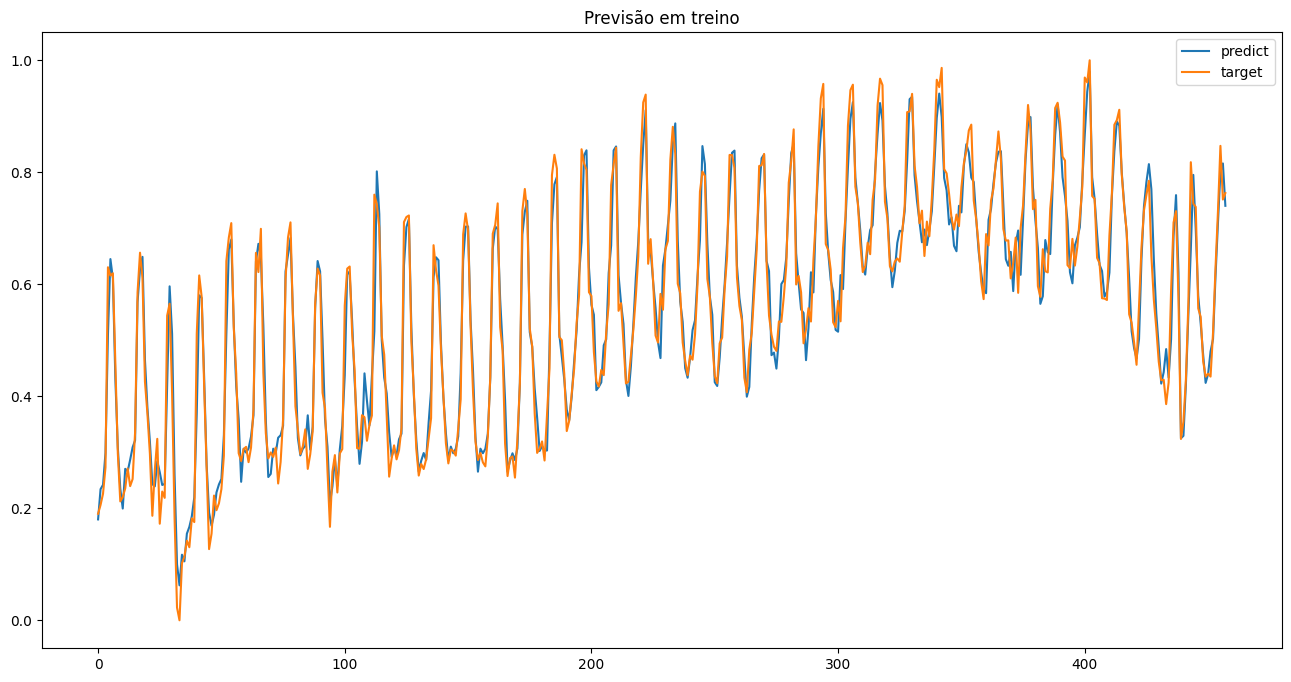

In [ ]:
plt.title("Previsão em treino")
plt.plot(prev_train, label = 'predict')
plt.plot(y_train_full, label = 'target')
plt.legend(loc = 'best')
plt.show()

In [ ]:
resultados = {
    "Métricas XGB - Train": ["MAPE", "MSE", "RMSE"],
    "Resultado XGB - Train": [MAPE(y_train_full, prev_train),
                              MSE(y_train_full, prev_train),
                              rmse(y_train_full, prev_train)]
}

df_resultados_XGB_train = pd.DataFrame(resultados)
df_resultados_XGB_train.set_index("Métricas XGB - Train", inplace=True)

df_resultados_XGB_train

,Resultado XGB - Train
Métricas XGB - Train,
MAPE,0.068269
MSE,0.001974
RMSE,0.044426


### Previsão em `teste`

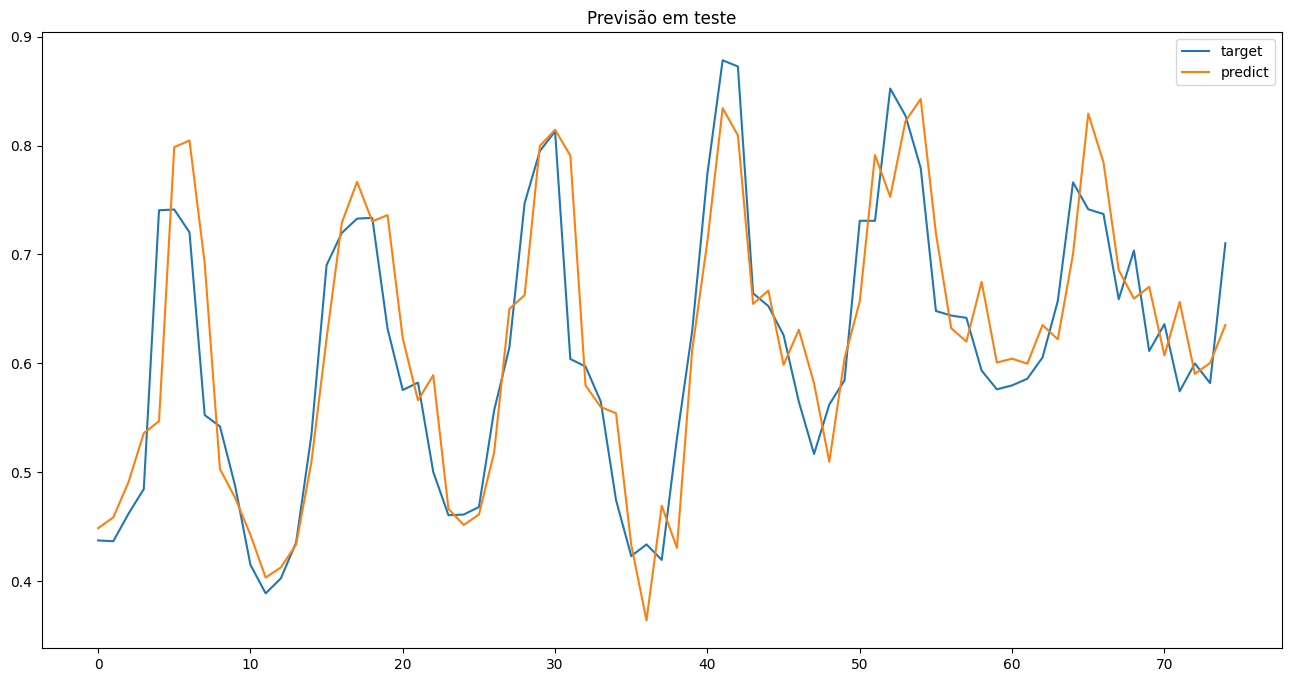

In [ ]:
plt.title("Previsão em teste")
plt.plot(y_test, label='target')
plt.plot(prev_test, label='predict')
plt.legend(loc='best')
plt.show()

### Métricas de erro

In [ ]:
resultados = {
    "Métricas XGB - Test": ["MAPE", "MSE", "RMSE"],
    "Resultado XGB - Test": [MAPE(y_test, prev_test),
                              MSE(y_test, prev_test),
                              rmse(y_test, prev_test)]
}

df_resultados_XGB_test = pd.DataFrame(resultados)
df_resultados_XGB_test.set_index("Métricas XGB - Test", inplace=True)

df_resultados_XGB_test

,Resultado XGB - Test
Métricas XGB - Test,
MAPE,0.072640
MSE,0.003561
RMSE,0.059672


## Comparando os modelos

In [ ]:
df_treino = pd.concat([df_resultados_MLP_train, df_resultados_XGB_train], axis=1)
df_treino

,Resultado MLP - Train,Resultado XGB - Train
MAPE,0.118065,0.068269
MSE,0.005596,0.001974
RMSE,0.074808,0.044426


In [ ]:
df_test = pd.concat([df_resultados_MLP_test, df_resultados_XGB_test], axis=1)
df_test

,Resultado MLP - Test,Resultado XGB - Test
MAPE,0.073634,0.072640
MSE,0.003369,0.003561
RMSE,0.058042,0.059672


> Interpretação dos resultados:
- Com base nessas métricas, escolheria o modelo XGBoost (XGB) porque apresenta um desempenho geral melhor do que a Rede Neural Multilayer Perceptron (MLP), tanto nos dados de treinamento quanto nos dados de teste. O XGBoost tem menor MAPE, MSE e RMSE em ambos os conjuntos de dados, indicando uma melhor capacidade de previsão e menor erro.